In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn as skl

from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout, Flatten

from sklearn.metrics import average_precision_score, mean_squared_error, roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LogisticRegression

from scipy.stats import pearsonr

import xgboost as xgb

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

base_path = "d:/work/stackoverflow/"
base_path_nn = base_path + "exp/nn/"

Using TensorFlow backend.


In [5]:
data = pd.read_csv(base_path + 'text3.csv')

In [22]:
arr = ['title_overlap', 'ans_count', 'questions_count', 'reached_people', 'user_rating', 'post_type']
for i, w in enumerate(arr):
    for j, v in enumerate(arr):
        if j != i:
            corr, _ = pearsonr(data[w], data[v])
            print('Pearsons corr of {} and {}: {}'.format(w, v, corr))

Pearsons corr of title_overlap and ans_count: 0.012529084419127274
Pearsons corr of title_overlap and questions_count: 0.00402793354284717
Pearsons corr of title_overlap and reached_people: 0.008413425476845177
Pearsons corr of title_overlap and user_rating: 0.011300141397323896
Pearsons corr of title_overlap and post_type: 0.01194633572533909
Pearsons corr of ans_count and title_overlap: 0.012529084419127274
Pearsons corr of ans_count and questions_count: 0.14786385567869664
Pearsons corr of ans_count and reached_people: 0.6290710359145083
Pearsons corr of ans_count and user_rating: 0.8346703288412607
Pearsons corr of ans_count and post_type: -0.018807659435680073
Pearsons corr of questions_count and title_overlap: 0.00402793354284717
Pearsons corr of questions_count and ans_count: 0.14786385567869664
Pearsons corr of questions_count and reached_people: 0.3920067829366788
Pearsons corr of questions_count and user_rating: 0.40054705600370255
Pearsons corr of questions_count and post_ty

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/device:GPU:0']

In [25]:
def data_divider(data, per=0.8, shuffle=True):
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    rr = round(len(data.index) * per)
    return data[:rr], data[rr:]

def get_norms(ser):
    return normalize(ser[:,np.newaxis], axis=0).ravel()
    #return [[i] for i in normalize(ser[:,np.newaxis], axis=0).ravel()]

In [26]:
data = pd.read_csv(base_path + 'text3.csv')
data = data[:50000]

#data['lda'] = [[float(b) for b in a.strip('[]').split(', ')] for a in data['lda']]
#data['lda'] = data['lda'].tolist()

data['title_overlap'] = get_norms(data['title_overlap'])
data['ans_count'] = get_norms(data['ans_count'])
data['questions_count'] = get_norms(data['questions_count'])
data['reached_people'] = get_norms(data['reached_people'])
data['user_rating'] = get_norms(data['user_rating'])

data = data.drop(['id_post', 'id_user', 'user_rating', 'ans_count'], axis=1)

train_data, test_data = data_divider(data)
x_train = train_data.drop('post_type', axis=1)
y_train = train_data['post_type']
x_test = test_data.drop('post_type', axis=1)
y_test = test_data['post_type']

data[:5]

,questions_count,reached_people,debug_inf,title_overlap,post_type,lda0,lda1,lda2,lda3,lda4,...,lda290,lda291,lda292,lda293,lda294,lda295,lda296,lda297,lda298,lda299
0,0.000156,5.716300e-07,0,0.000000,2,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.001131,2.486462e-04,0,0.004777,2,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.019340,8.971771e-03,0,0.005012,2,0.0,0.0,0.0,0.050483,0.0,...,0.024479,0.024474,0.0,0.0,0.024297,0.0,0.0,0.0,0.0,0.0
3,0.000312,1.384216e-06,0,0.004746,2,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000078,6.152072e-07,0,0.000000,2,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [27]:
classifier = Sequential()

classifier.add(Dense(output_dim = 30, init = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
#classifier.add(Dropout(0.2, noise_shape=None, seed=None))

#classifier.add(Dense(output_dim = 180, init = 'uniform', activation = 'relu'))
#classifier.add(Dropout(0.2, noise_shape=None, seed=None))

#classifier.add(Dense(output_dim = 100, init = 'uniform', activation = 'relu'))
#classifier.add(Dropout(0.3, noise_shape=None, seed=None))

#classifier.add(Dense(output_dim = 30, init = 'uniform', activation = 'relu'))
#classifier.add(Dropout(0.4, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.4, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 3, init = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

d:\programs\python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=304, units=30, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to th

In [28]:
classifier.summary()

history = classifier.fit(x_train, y_train, validation_split=0.2, batch_size = 128, nb_epoch = 50, verbose=1)

#classifier.save("model_tmp.ser")

d:\programs\python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                9150      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)               

Epoch 43/50
32000/32000 [==============================] - 2s 50us/step - loss: 0.7895 - accuracy: 0.6553 - val_loss: 0.7988 - val_accuracy: 0.6501
Epoch 44/50
32000/32000 [==============================] - 2s 50us/step - loss: 0.7897 - accuracy: 0.6553 - val_loss: 0.7988 - val_accuracy: 0.6501
Epoch 45/50
32000/32000 [==============================] - 2s 54us/step - loss: 0.7898 - accuracy: 0.6553 - val_loss: 0.7988 - val_accuracy: 0.6501
Epoch 46/50
32000/32000 [==============================] - 2s 78us/step - loss: 0.7894 - accuracy: 0.6553 - val_loss: 0.7988 - val_accuracy: 0.6501
Epoch 47/50
32000/32000 [==============================] - 2s 70us/step - loss: 0.7893 - accuracy: 0.6553 - val_loss: 0.7989 - val_accuracy: 0.6501
Epoch 48/50
32000/32000 [==============================] - 2s 69us/step - loss: 0.7897 - accuracy: 0.6553 - val_loss: 0.7988 - val_accuracy: 0.6501
Epoch 49/50
32000/32000 [==============================] - 2s 62us/step - loss: 0.7894 - accuracy: 0.6553 - val_

In [29]:
def res_eval(goal, res):
    #eval_res(res, y_test, history)
    print('classification report')
    print(classification_report(goal, res))
    print('confusion matrix')
    print(skl.metrics.confusion_matrix(goal, res))
    f1_score = skl.metrics.f1_score(goal, res, average="micro")
    print('F1 score: {}'.format(f1_score))
    
    fpr, tpr, thresholds = roc_curve(goal, res, pos_label=2)
    au_curve = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {:.3f}'.format(au_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

classification report


d:\programs\python3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       510
           1       0.00      0.00      0.00      2943
           2       0.65      1.00      0.79      6547

    accuracy                           0.65     10000
   macro avg       0.22      0.33      0.26     10000
weighted avg       0.43      0.65      0.52     10000

confusion matrix
[[   0    0  510]
 [   0    0 2943]
 [   0    0 6547]]
F1 score: 0.6547


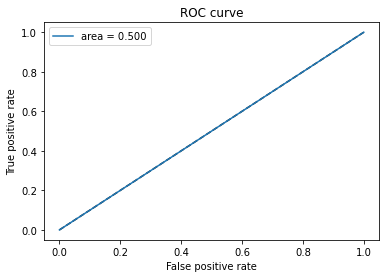

Train: 0.654, Test: 0.655


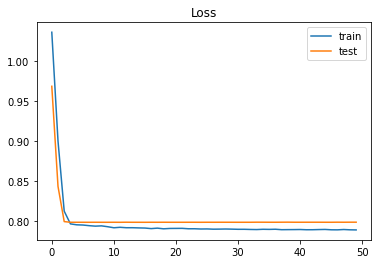

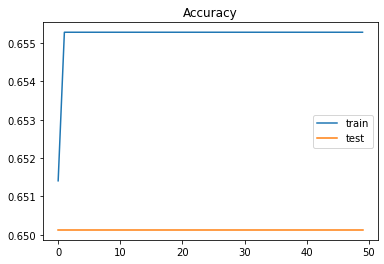

In [30]:
prediction = classifier.predict(x_test).tolist()
plot_model(classifier, to_file="model.png")

res = np.argmax(prediction, axis=1)

res_eval(y_test, res)
        
_, train_acc = classifier.evaluate(x_train, y_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

plt.figure(1)
#plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.figure(2)
#plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [39]:
weights = classifier.get_weights()
for w in weights:
    print(w.shape)

(306, 30)
(30,)
(30, 20)
(20,)
(20, 10)
(10,)
(10, 10)
(10,)
(10, 5)
(5,)
(5, 5)
(5,)
(5, 3)
(3,)


In [6]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
res = model.predict(x_test)
res_eval(y_test, res)

classification report
              precision    recall  f1-score   support

           0       0.37      0.01      0.02      1746
           1       0.61      0.23      0.33      6226
           2       0.68      0.94      0.79     14556

    accuracy                           0.67     22528
   macro avg       0.55      0.39      0.38     22528
weighted avg       0.64      0.67      0.60     22528

confusion matrix
[[   14   109  1623]
 [    2  1405  4819]
 [   22   779 13755]]


NameError: name 'prediction' is not defined

classification report
              precision    recall  f1-score   support

           0       0.37      0.01      0.02      1746
           1       0.61      0.23      0.33      6226
           2       0.68      0.94      0.79     14556

    accuracy                           0.67     22528
   macro avg       0.55      0.39      0.38     22528
weighted avg       0.64      0.67      0.60     22528

confusion matrix
[[   14   109  1623]
 [    2  1405  4819]
 [   22   779 13755]]
F1 score: 0.6735617897727273


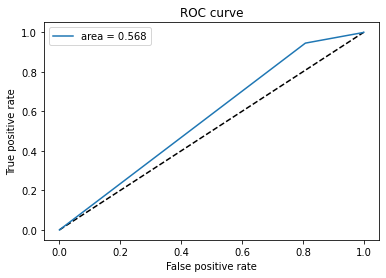

In [10]:
goal = y_test
print('classification report')
print(classification_report(goal, res))
print('confusion matrix')
print(skl.metrics.confusion_matrix(goal, res))
f1_score = skl.metrics.f1_score(goal, res, average="micro")
print('F1 score: {}'.format(f1_score))
    
fpr, tpr, thresholds = roc_curve(goal, res, pos_label=2)
au_curve = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(au_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
model.save_model('xgb_tmp.ser')